# Bank Marketing EDA — Decision Tree / Random Forest

**Dataset:** UCI Bank Marketing (Moro et al., 2014)  
**Source:** Portuguese banking institution — direct marketing campaigns (phone calls)  
**Samples:** 41,188 | **Features:** 20 input + 1 binary target (`y`: term deposit subscription)  
**Task:** Predict whether a client subscribes to a term deposit (yes/no)

## Purpose
Inspect raw data before any preprocessing touches it:
- Verify distributions, detect outliers and anomalies
- Identify data leakage (`duration` column)
- Quantify class imbalance (88.7% no / 11.3% yes)
- Statistical tests: chi-squared (categorical), normality, VIF (multicollinearity)
- Every finding maps to a specific preprocessing decision

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import urllib.request
import zipfile
import io
import os

# Configuration
RAW_DIR = Path('../data/raw')
DATASET_URL = 'https://archive.ics.uci.edu/static/public/222/bank+marketing.zip'
CSV_FILENAME = 'bank-additional-full.csv'

# Download and extract if not already present
csv_path = RAW_DIR / CSV_FILENAME
if not csv_path.exists():
    print("Downloading Bank Marketing dataset from UCI...")
    RAW_DIR.mkdir(parents=True, exist_ok=True)
    
    zip_path = RAW_DIR / 'bank-marketing.zip'
    urllib.request.urlretrieve(DATASET_URL, zip_path)
    print(f"    Downloaded: {zip_path}")
    
    # UCI nests zips: outer zip contains bank-additional.zip,
    # which contains bank-additional/bank-additional-full.csv
    with zipfile.ZipFile(zip_path, 'r') as outer_zip:
        print(f"    Outer zip contents: {outer_zip.namelist()}")
        
        # Find the inner zip that contains our target CSV
        inner_zips = [f for f in outer_zip.namelist() if f.endswith('.zip')]
        
        for inner_name in inner_zips:
            inner_bytes = outer_zip.read(inner_name)
            with zipfile.ZipFile(io.BytesIO(inner_bytes)) as inner_zip:
                csv_matches = [f for f in inner_zip.namelist() if CSV_FILENAME in f]
                if csv_matches:
                    print(f"    Found in {inner_name}: {csv_matches}")
                    with inner_zip.open(csv_matches[0]) as src:
                        csv_path.write_bytes(src.read())
                    print(f"    Extracted to: {csv_path}")
                    break
    
    # Clean up zip
    zip_path.unlink()
    print("    Cleaned up zip file")
else:
    print(f"Dataset already exists: {csv_path}")

# Load raw data
print("=" * 60)
print("LOADING RAW DATA")
print("=" * 60)
df = pd.read_csv(csv_path, sep=';')
print(f"\nShape: {df.shape}")
print(f"Columns ({len(df.columns)}): {list(df.columns)}")
print(f"\nData types:\n{df.dtypes}")
print(f"\n{df.head()}")
print(f"\n{df.describe()}")

    Downloaded: ..\data\raw\bank-marketing.zip
    Outer zip contents: ['bank.zip', 'bank-additional.zip']
    Found in bank-additional.zip: ['bank-additional/bank-additional-full.csv']
    Extracted to: ..\data\raw\bank-additional-full.csv
    Cleaned up zip file
LOADING RAW DATA

Shape: (41188, 21)
Columns (21): ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']

Data types:
age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price

In [3]:
# Step 1: Missing values and "unknown" audit
# Bank Marketing uses "unknown" as a string instead of NaN
# Trees CAN handle this as a category, but we need to know the scale
print("=" * 60)
print("[1/12] MISSING VALUES & 'UNKNOWN' AUDIT")
print("=" * 60)

# Traditional NaN check
print("\n--- Traditional NaN count ---")
print(df.isnull().sum().to_string())
print(f"\nTotal NaN: {df.isnull().sum().sum()}")

# "unknown" check across all object columns
print("\n--- 'unknown' counts per column ---")
object_cols = df.select_dtypes(include='object').columns
unknown_counts = {}
for col in object_cols:
    count = (df[col] == 'unknown').sum()
    if count > 0:
        pct = count / len(df) * 100
        unknown_counts[col] = {'count': count, 'pct': round(pct, 2)}
        print(f"  {col:12s}: {count:6d} ({pct:.2f}%)")

if not unknown_counts:
    print("  No 'unknown' values found")

print(f"\nTotal 'unknown' cells: {sum(v['count'] for v in unknown_counts.values())}")
print(f"Decision: Keep 'unknown' as its own category — trees split on it naturally")

[1/12] MISSING VALUES & 'UNKNOWN' AUDIT

--- Traditional NaN count ---
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0

Total NaN: 0

--- 'unknown' counts per column ---
  job         :    330 (0.80%)
  marital     :     80 (0.19%)
  education   :   1731 (4.20%)
  default     :   8597 (20.87%)
  housing     :    990 (2.40%)
  loan        :    990 (2.40%)

Total 'unknown' cells: 12718
Decision: Keep 'unknown' as its own category — trees split on it naturally


[2/12] TARGET DISTRIBUTION

Target ('y') value counts:
  no   :  36548 (88.73%)
  yes  :   4640 (11.27%)

Imbalance ratio: 7.9 : 1


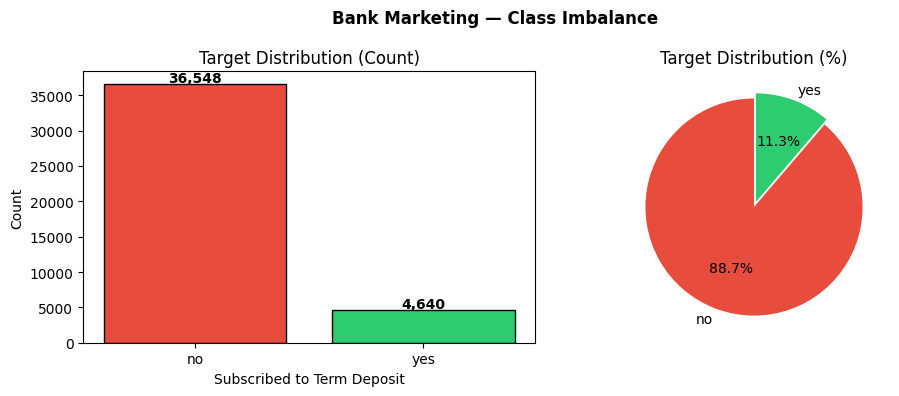


Saved: eda_target_distribution.png
Action: Use class_weight='balanced' across all frameworks


In [4]:
# Step 2: Target distribution and class imbalance
print("=" * 60)
print("[2/12] TARGET DISTRIBUTION")
print("=" * 60)

target_counts = df['y'].value_counts()
target_pcts = df['y'].value_counts(normalize=True) * 100

print("\nTarget ('y') value counts:")
for val in target_counts.index:
    print(f"  {val:5s}: {target_counts[val]:6d} ({target_pcts[val]:.2f}%)")

print(f"\nImbalance ratio: {target_counts['no'] / target_counts['yes']:.1f} : 1")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Bar chart
colors = ['#e74c3c', '#2ecc71']  # red=no, green=yes
axes[0].bar(target_counts.index, target_counts.values, color=colors, edgecolor='black')
axes[0].set_title('Target Distribution (Count)')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Subscribed to Term Deposit')
for i, (val, count) in enumerate(zip(target_counts.index, target_counts.values)):
    axes[0].text(i, count + 300, f'{count:,}', ha='center', fontweight='bold')

# Pie chart
axes[1].pie(target_counts.values, labels=target_counts.index, colors=colors,
            autopct='%1.1f%%', startangle=90, explode=(0, 0.05))
axes[1].set_title('Target Distribution (%)')

plt.suptitle('Bank Marketing — Class Imbalance', fontweight='bold')
plt.tight_layout()
plt.savefig('../data/raw/eda_target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nSaved: eda_target_distribution.png")
print("Action: Use class_weight='balanced' across all frameworks")

[3/12] NUMERIC FEATURE DISTRIBUTIONS
Numeric features (10): ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


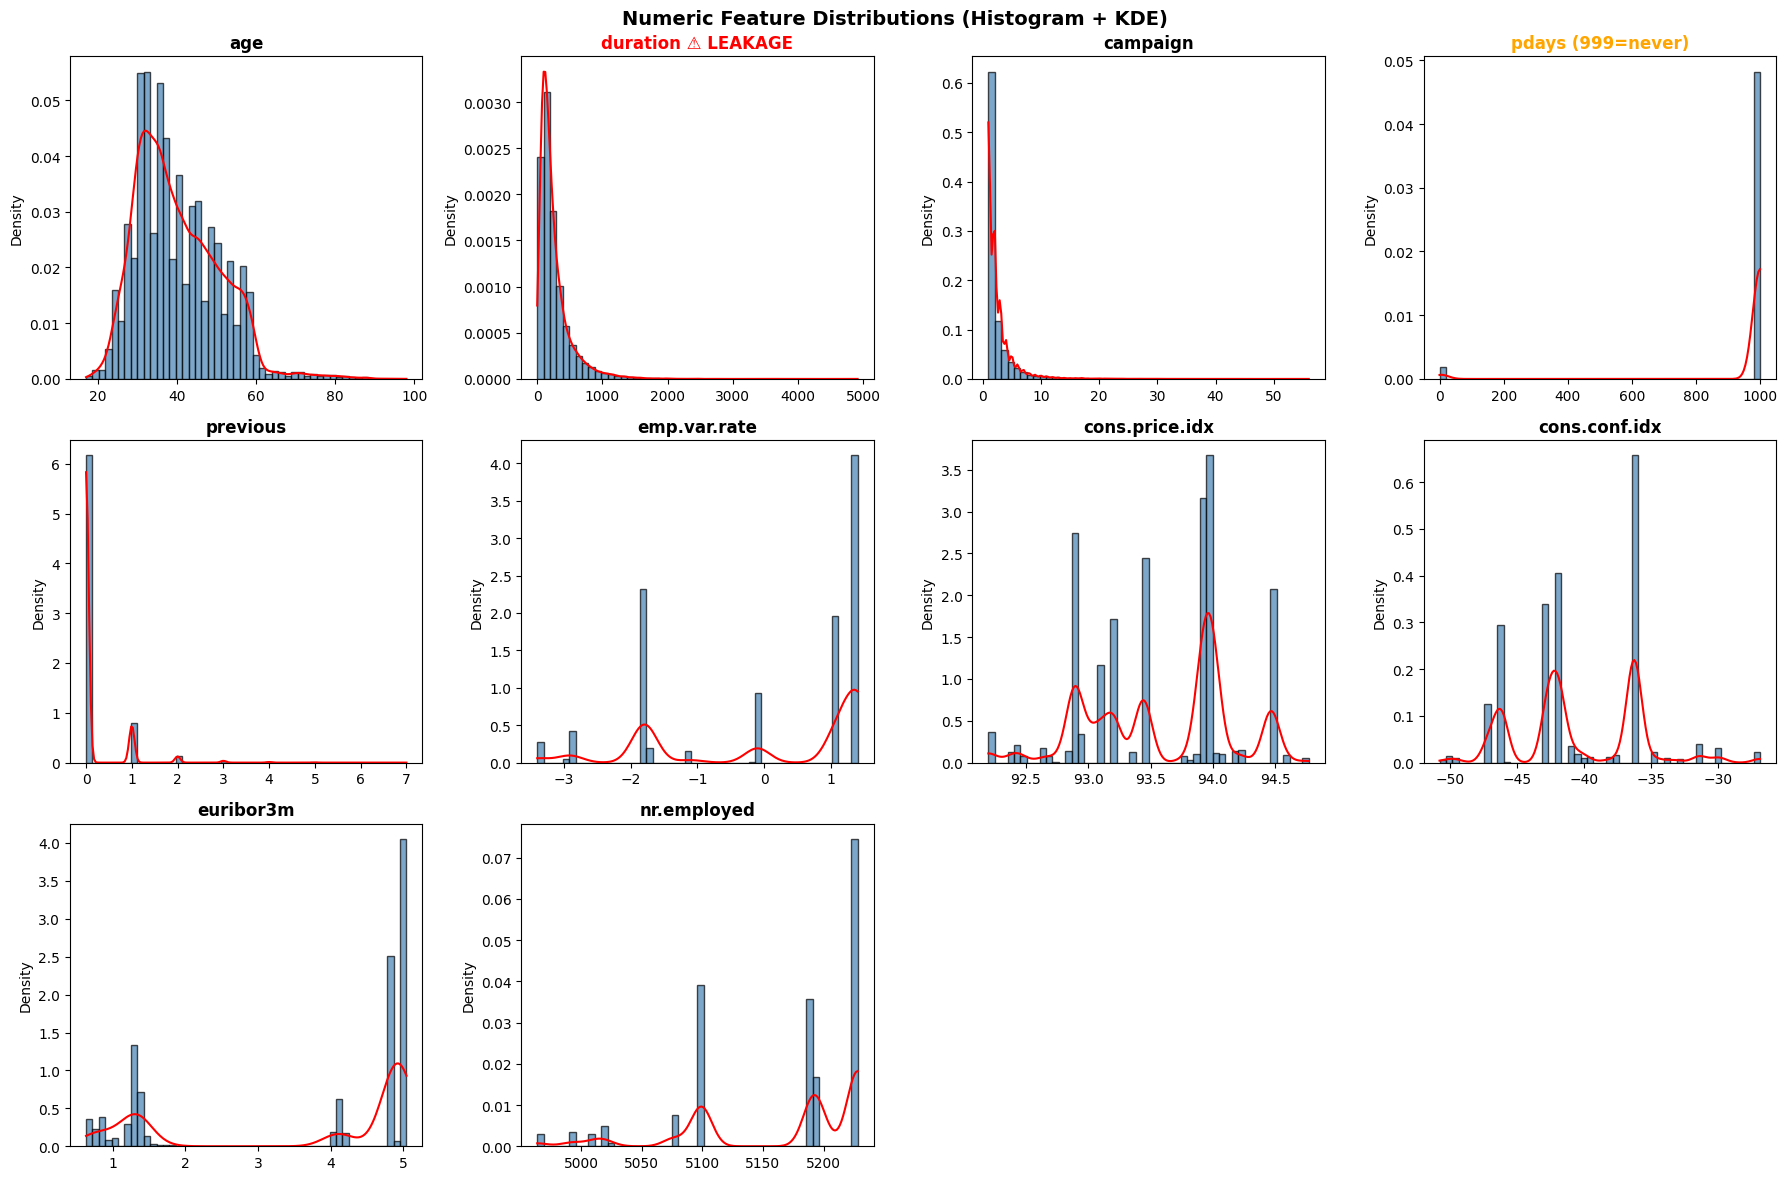


Saved: eda_numeric_distributions.png

Skewness:
  age                 :    0.785
  duration            :    3.263 ← highly skewed
  campaign            :    4.763 ← highly skewed
  pdays               :   -4.922 ← highly skewed
  previous            :    3.832 ← highly skewed
  emp.var.rate        :   -0.724
  cons.price.idx      :   -0.231
  cons.conf.idx       :    0.303
  euribor3m           :   -0.709
  nr.employed         :   -1.044


In [5]:
# Step 3: Numeric feature distributions
print("=" * 60)
print("[3/12] NUMERIC FEATURE DISTRIBUTIONS")
print("=" * 60)

numeric_cols = df.select_dtypes(include='number').columns.tolist()
print(f"Numeric features ({len(numeric_cols)}): {numeric_cols}")

fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    ax.hist(df[col], bins=50, color='steelblue', edgecolor='black', alpha=0.7, density=True)
    
    # KDE overlay
    try:
        kde_x = np.linspace(df[col].min(), df[col].max(), 200)
        kde = stats.gaussian_kde(df[col])
        ax.plot(kde_x, kde(kde_x), color='red', linewidth=1.5)
    except Exception:
        pass  # KDE can fail on degenerate distributions
    
    ax.set_title(col, fontweight='bold')
    ax.set_ylabel('Density')
    
    # Flag special columns
    if col == 'duration':
        ax.set_title(f'{col} ⚠ LEAKAGE', fontweight='bold', color='red')
    elif col == 'pdays':
        ax.set_title(f'{col} (999=never)', fontweight='bold', color='orange')

# Hide unused subplots
for j in range(len(numeric_cols), len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Numeric Feature Distributions (Histogram + KDE)', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('../data/raw/eda_numeric_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nSaved: eda_numeric_distributions.png")

# Print skewness for context
print("\nSkewness:")
for col in numeric_cols:
    skew = df[col].skew()
    flag = " ← highly skewed" if abs(skew) > 2 else ""
    print(f"  {col:20s}: {skew:8.3f}{flag}")

[4/12] CATEGORICAL FEATURE DISTRIBUTIONS
Categorical features (10): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


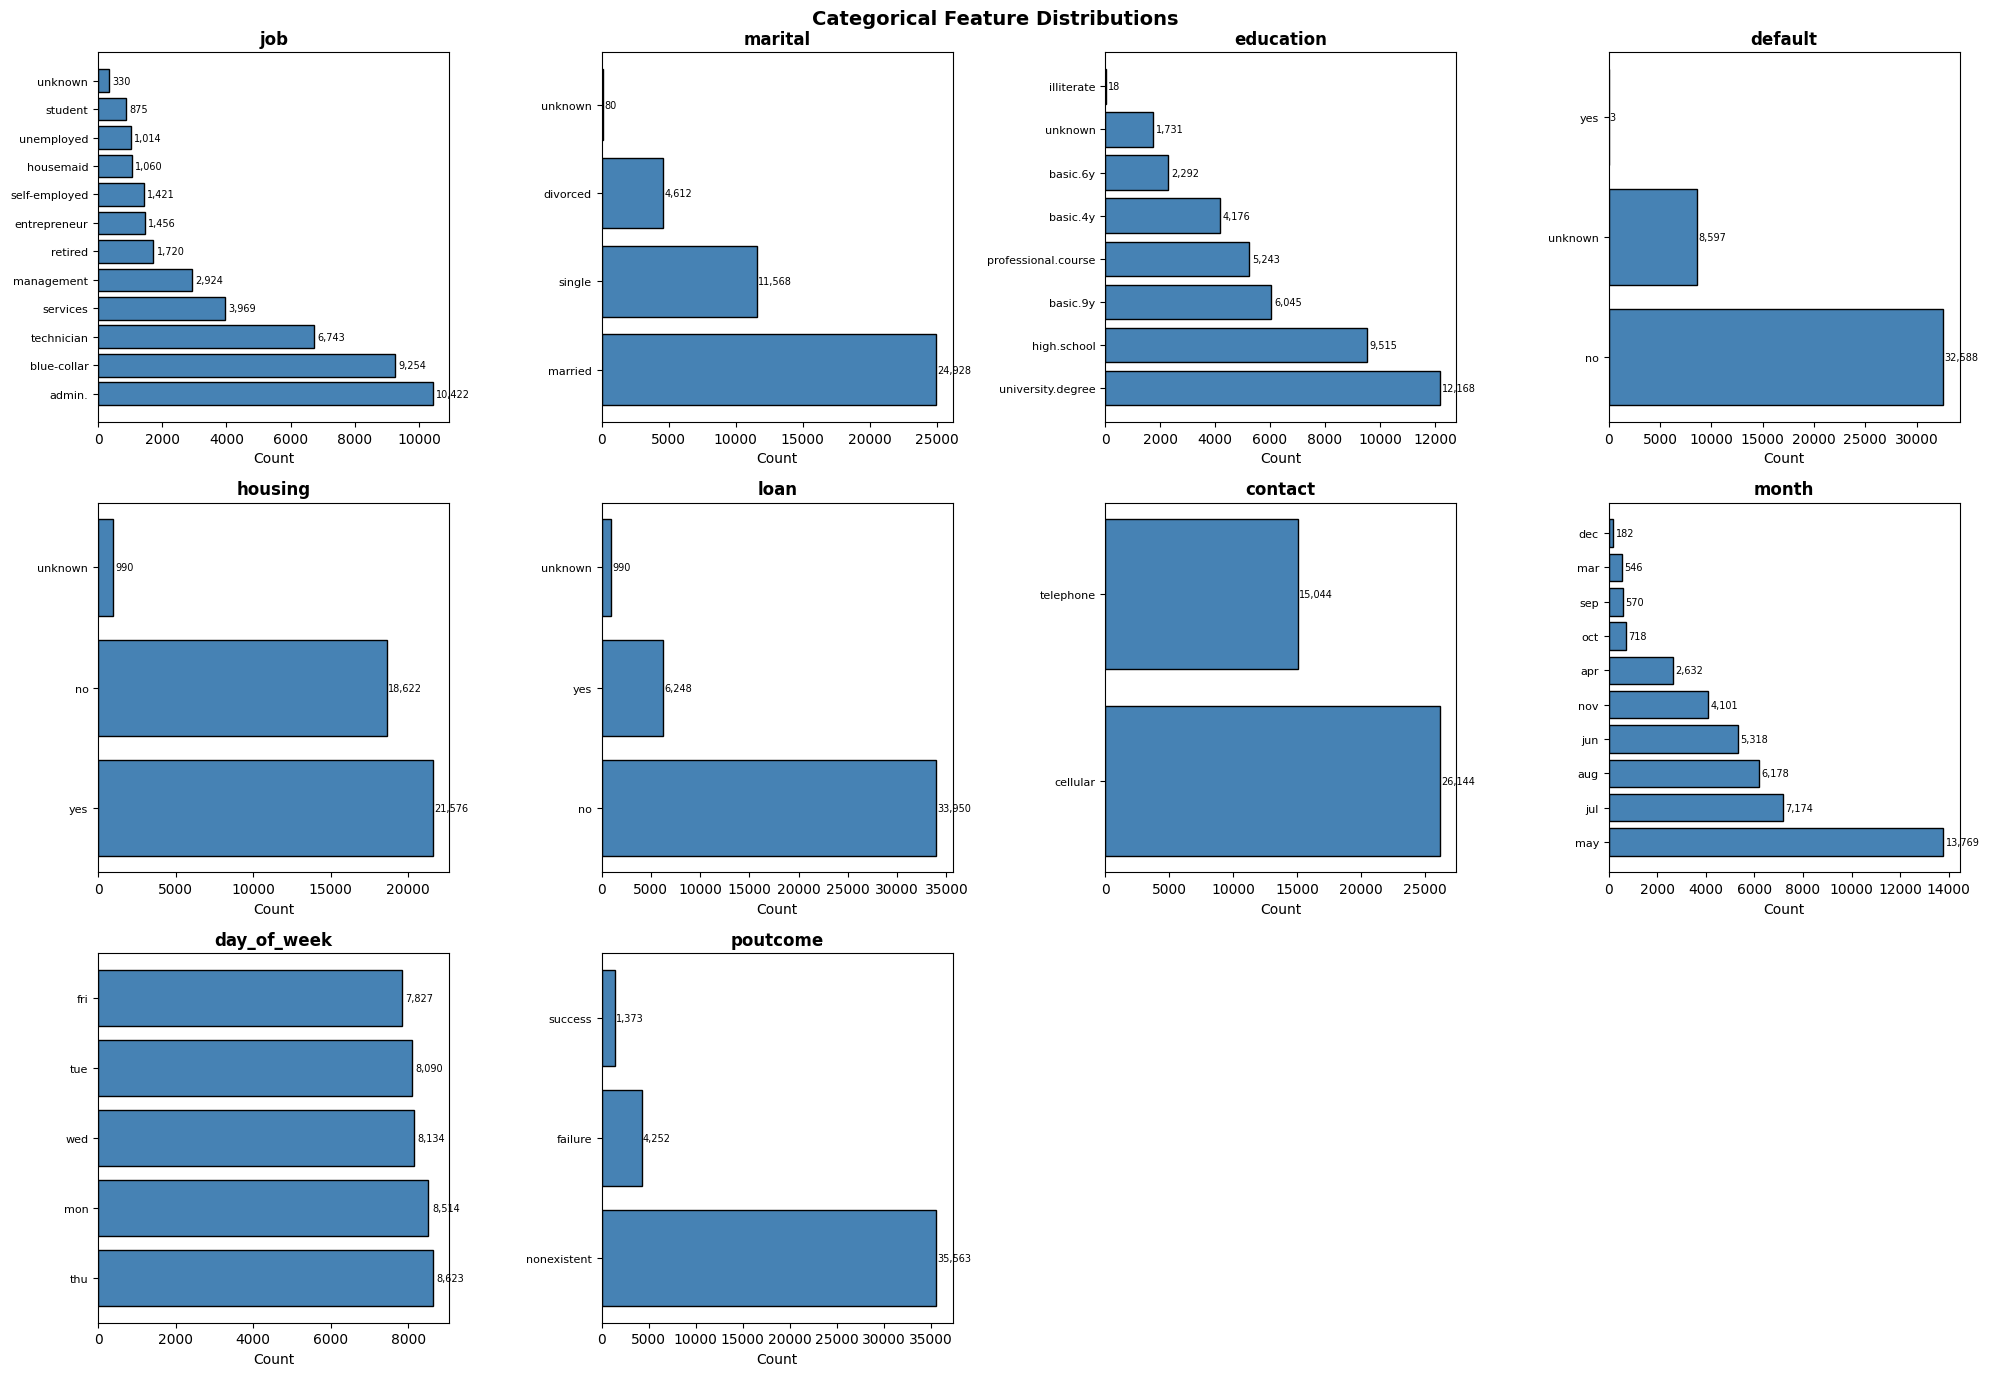


Saved: eda_categorical_distributions.png

Category counts per feature:
  job            : 12 categories — ['housemaid', 'services', 'admin.', 'blue-collar', 'technician', 'retired', 'management', 'unemployed', 'self-employed', 'unknown', 'entrepreneur', 'student']
  marital        :  4 categories — ['married', 'single', 'divorced', 'unknown']
  education      :  8 categories — ['basic.4y', 'high.school', 'basic.6y', 'basic.9y', 'professional.course', 'unknown', 'university.degree', 'illiterate']
  default        :  3 categories — ['no', 'unknown', 'yes']
  housing        :  3 categories — ['no', 'yes', 'unknown']
  loan           :  3 categories — ['no', 'yes', 'unknown']
  contact        :  2 categories — ['telephone', 'cellular']
  month          : 10 categories — ['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'mar', 'apr', 'sep']
  day_of_week    :  5 categories — ['mon', 'tue', 'wed', 'thu', 'fri']
  poutcome       :  3 categories — ['nonexistent', 'failure', 'success']


In [6]:
# Step 4: Categorical feature distributions
print("=" * 60)
print("[4/12] CATEGORICAL FEATURE DISTRIBUTIONS")
print("=" * 60)

cat_cols = df.select_dtypes(include='object').columns.drop('y')  # exclude target
print(f"Categorical features ({len(cat_cols)}): {list(cat_cols)}")

fig, axes = plt.subplots(3, 4, figsize=(20, 14))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ax = axes[i]
    counts = df[col].value_counts()
    bars = ax.barh(range(len(counts)), counts.values, color='steelblue', edgecolor='black')
    ax.set_yticks(range(len(counts)))
    ax.set_yticklabels(counts.index, fontsize=8)
    ax.set_title(col, fontweight='bold')
    ax.set_xlabel('Count')
    
    # Label bars with counts
    for j, (val, count) in enumerate(zip(counts.index, counts.values)):
        ax.text(count + 100, j, f'{count:,}', va='center', fontsize=7)

# Hide unused subplots
for j in range(len(cat_cols), len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Categorical Feature Distributions', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('../data/raw/eda_categorical_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nSaved: eda_categorical_distributions.png")

# Print unique value counts
print("\nCategory counts per feature:")
for col in cat_cols:
    n_unique = df[col].nunique()
    print(f"  {col:15s}: {n_unique:2d} categories — {list(df[col].unique())}")

[5/12] OUTLIER DETECTION — BOX PLOTS + IQR


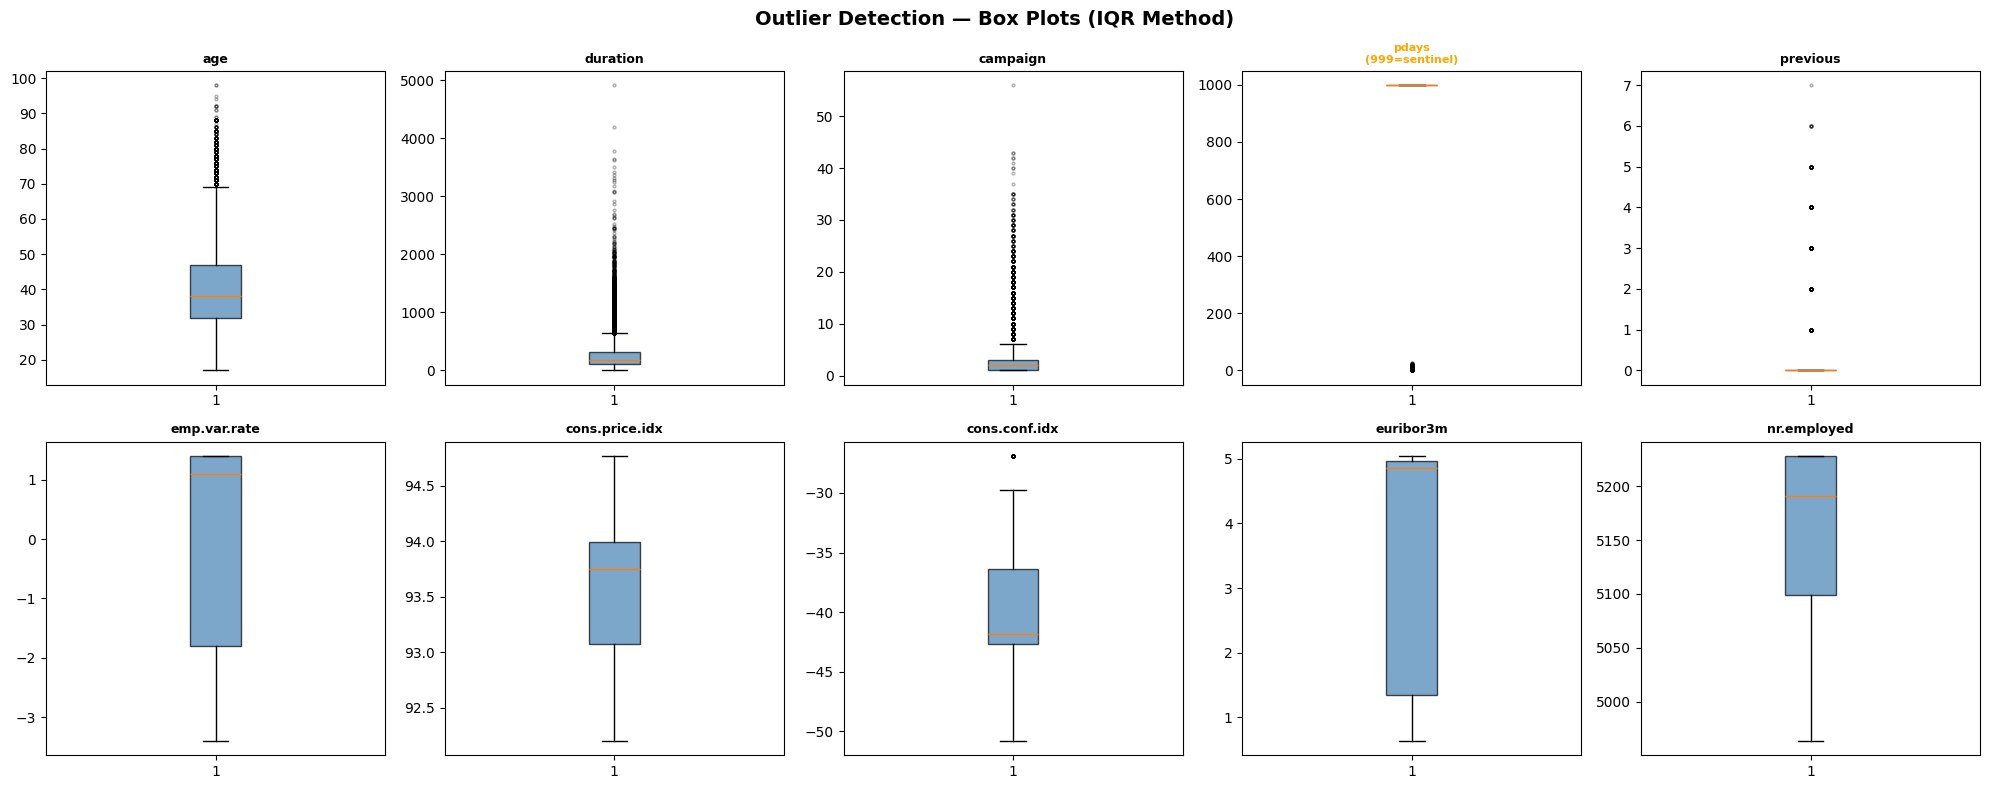


Saved: eda_outlier_boxplots.png

Feature              Outliers       %       Lower       Upper
------------------------------------------------------------
age                       469   1.14%        9.50       69.50
duration                 2963   7.19%     -223.50      644.50
campaign                 2406   5.84%       -2.00        6.00
pdays                    1515   3.68%      999.00      999.00 ← sentinel excluded
previous                 5625  13.66%        0.00        0.00
emp.var.rate                0   0.00%       -6.60        6.20
cons.price.idx              0   0.00%       91.70       95.37
cons.conf.idx             447   1.09%      -52.15      -26.95
euribor3m                   0   0.00%       -4.08       10.39
nr.employed                 0   0.00%     4905.60     5421.60

Decision: Keep all outliers — trees split on thresholds, robust to extreme values
(Unlike distance-based models like KNN where outliers distort predictions)


In [7]:
# Step 5: Outlier detection (numeric features)
print("=" * 60)
print("[5/12] OUTLIER DETECTION — BOX PLOTS + IQR")
print("=" * 60)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

outlier_summary = {}
for i, col in enumerate(numeric_cols):
    ax = axes[i]
    
    # Box plot
    bp = ax.boxplot(df[col], vert=True, patch_artist=True,
                    boxprops=dict(facecolor='steelblue', alpha=0.7),
                    flierprops=dict(marker='o', markersize=2, alpha=0.3))
    ax.set_title(col, fontweight='bold', fontsize=9)
    
    # IQR calculation
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Skip pdays — 999 is a sentinel, not an outlier
    if col == 'pdays':
        outliers = df[(df[col] < lower) & (df[col] != 999) | 
                      (df[col] > upper) & (df[col] != 999)]
        ax.set_title(f'{col}\n(999=sentinel)', fontweight='bold', fontsize=8, color='orange')
    else:
        outliers = df[(df[col] < lower) | (df[col] > upper)]
    
    n_outliers = len(outliers)
    pct = n_outliers / len(df) * 100
    outlier_summary[col] = {'count': n_outliers, 'pct': round(pct, 2),
                            'lower': round(lower, 2), 'upper': round(upper, 2)}

plt.suptitle('Outlier Detection — Box Plots (IQR Method)', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('../data/raw/eda_outlier_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nSaved: eda_outlier_boxplots.png")

# Print outlier summary
print(f"\n{'Feature':20s} {'Outliers':>8s} {'%':>7s}  {'Lower':>10s}  {'Upper':>10s}")
print("-" * 60)
for col, info in outlier_summary.items():
    flag = " ← sentinel excluded" if col == 'pdays' else ""
    print(f"{col:20s} {info['count']:8d} {info['pct']:6.2f}%  {info['lower']:10.2f}  {info['upper']:10.2f}{flag}")

print("\nDecision: Keep all outliers — trees split on thresholds, robust to extreme values")
print("(Unlike distance-based models like KNN where outliers distort predictions)")

[6/12] CORRELATION HEATMAP — NUMERIC FEATURES


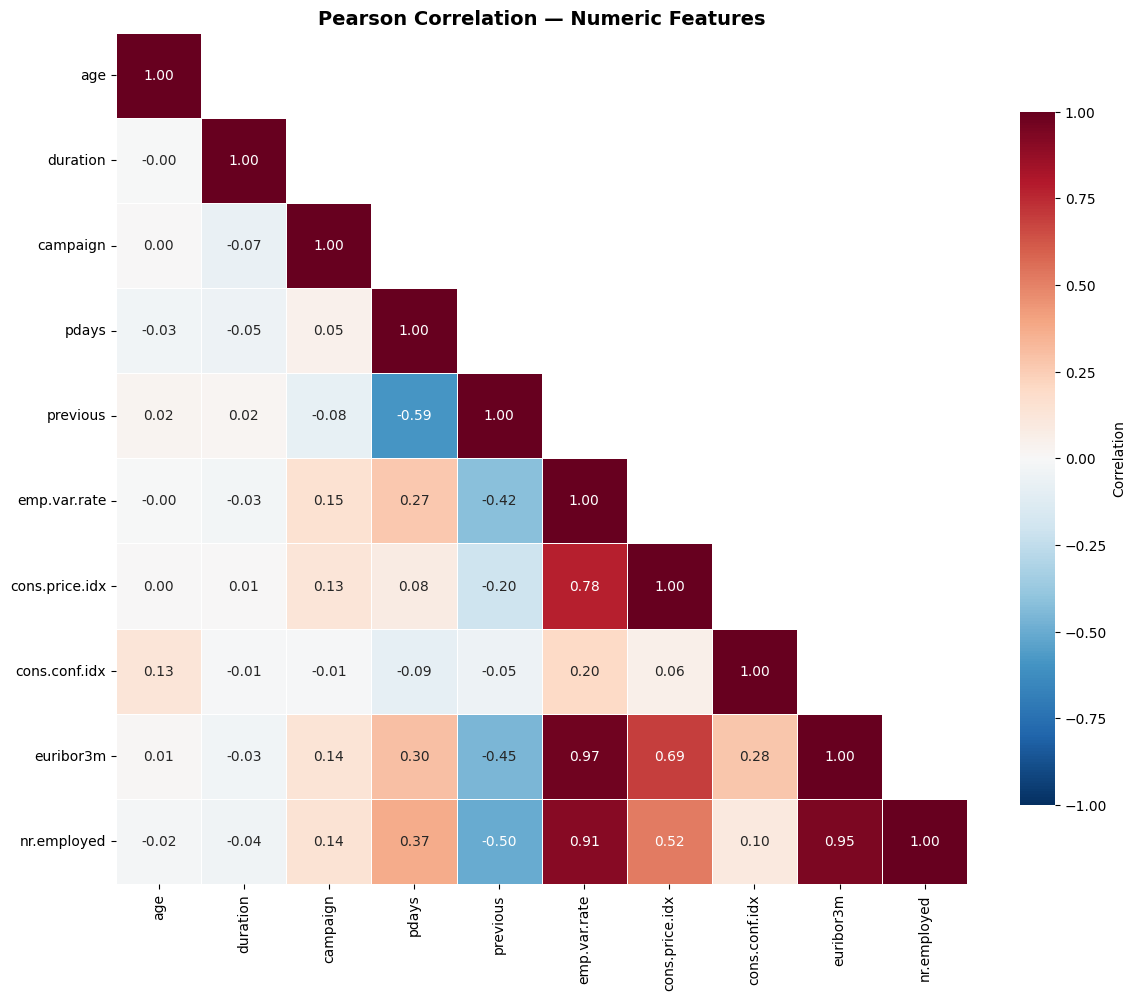


Saved: eda_correlation_heatmap.png

Strongly correlated pairs (|r| > 0.7):
--------------------------------------------------
  emp.var.rate         ↔ cons.price.idx      : r = 0.775
  emp.var.rate         ↔ euribor3m           : r = 0.972
  emp.var.rate         ↔ nr.employed         : r = 0.907
  euribor3m            ↔ nr.employed         : r = 0.945

Note: Trees select ONE feature per split, so multicollinearity
doesn't cause instability like it does in linear models.
High correlation just means redundant features — RF handles this
via random feature subsets (max_features='sqrt').


In [8]:
# Step 6: Correlation heatmap (numeric features)
print("=" * 60)
print("[6/12] CORRELATION HEATMAP — NUMERIC FEATURES")
print("=" * 60)

corr_matrix = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)  # hide upper triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, square=True, linewidths=0.5,
            cbar_kws={'shrink': 0.8, 'label': 'Correlation'},
            ax=ax)
ax.set_title('Pearson Correlation — Numeric Features', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('../data/raw/eda_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nSaved: eda_correlation_heatmap.png")

# Print strongly correlated pairs (|r| > 0.7)
print("\nStrongly correlated pairs (|r| > 0.7):")
print("-" * 50)
pairs_found = False
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        r = corr_matrix.iloc[i, j]
        if abs(r) > 0.7:
            pairs_found = True
            print(f"  {corr_matrix.columns[i]:20s} ↔ {corr_matrix.columns[j]:20s}: r = {r:.3f}")

if not pairs_found:
    print("  None found")

print("\nNote: Trees select ONE feature per split, so multicollinearity")
print("doesn't cause instability like it does in linear models.")
print("High correlation just means redundant features — RF handles this")
print("via random feature subsets (max_features='sqrt').")

[7/12] FEATURE-TARGET RELATIONSHIPS — NUMERIC


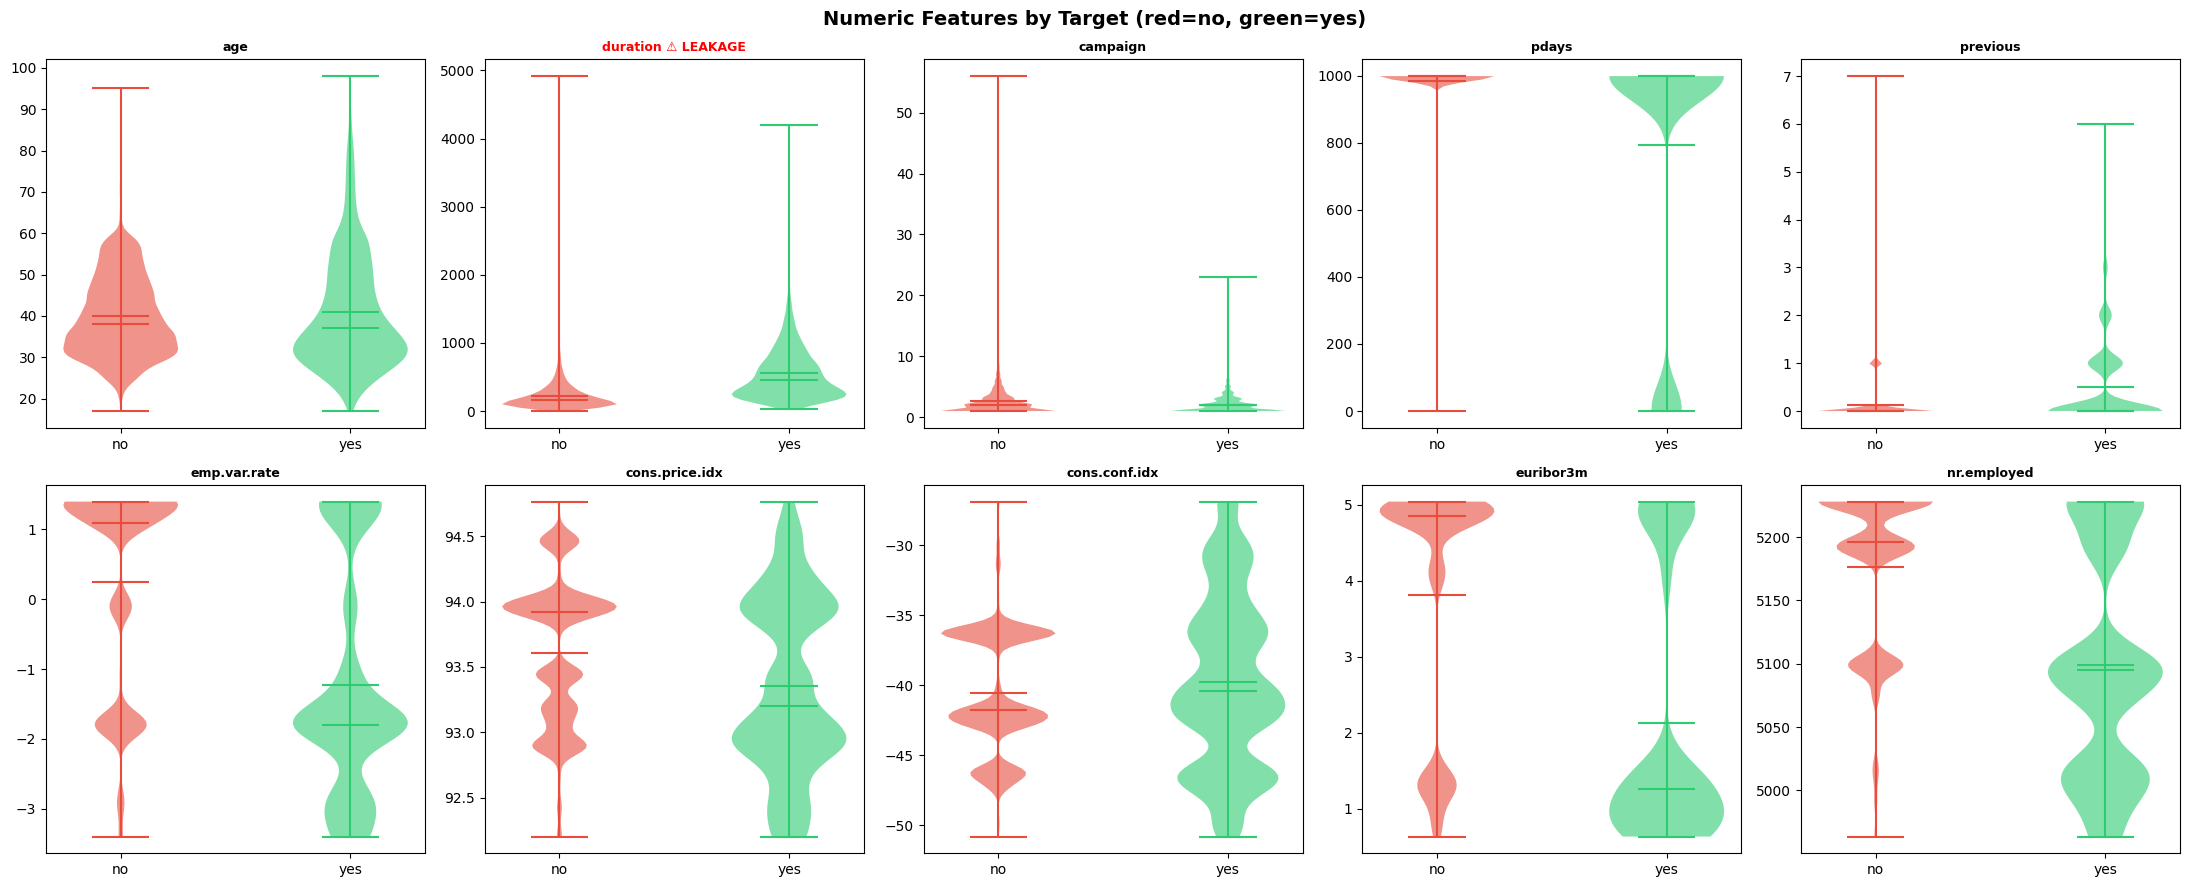


Saved: eda_numeric_vs_target.png

Feature                 Mean (no)   Mean (yes)     Diff %
----------------------------------------------------------
age                         39.91        40.91      +2.5%
duration                   220.84       553.19    +150.5% ← LEAKAGE
campaign                     2.63         2.05     -22.1%
pdays                      984.11       792.04     -19.5%
previous                     0.13         0.49    +272.2%
emp.var.rate                 0.25        -1.23    -595.6%
cons.price.idx              93.60        93.35      -0.3%
cons.conf.idx              -40.59       -39.79      -2.0%
euribor3m                    3.81         2.12     -44.3%
nr.employed               5176.17      5095.12      -1.6%


In [9]:
# Step 7: Feature-target relationships (numeric)
# Distribution of each numeric feature split by target (yes/no)
print("=" * 60)
print("[7/12] FEATURE-TARGET RELATIONSHIPS — NUMERIC")
print("=" * 60)

fig, axes = plt.subplots(2, 5, figsize=(22, 9))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    
    # Violin plots split by target
    for label, color in [('no', '#e74c3c'), ('yes', '#2ecc71')]:
        data = df[df['y'] == label][col]
        parts = ax.violinplot(data, positions=[0 if label == 'no' else 1],
                              showmeans=True, showmedians=True)
        for pc in parts['bodies']:
            pc.set_facecolor(color)
            pc.set_alpha(0.6)
        for key in ['cmeans', 'cmedians', 'cbars', 'cmins', 'cmaxes']:
            parts[key].set_color(color)
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['no', 'yes'])
    ax.set_title(col, fontweight='bold', fontsize=9)
    
    if col == 'duration':
        ax.set_title(f'{col} ⚠ LEAKAGE', fontweight='bold', fontsize=9, color='red')

plt.suptitle('Numeric Features by Target (red=no, green=yes)', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('../data/raw/eda_numeric_vs_target.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nSaved: eda_numeric_vs_target.png")

# Print mean differences
print(f"\n{'Feature':20s} {'Mean (no)':>12s} {'Mean (yes)':>12s} {'Diff %':>10s}")
print("-" * 58)
for col in numeric_cols:
    mean_no = df[df['y'] == 'no'][col].mean()
    mean_yes = df[df['y'] == 'yes'][col].mean()
    diff_pct = (mean_yes - mean_no) / mean_no * 100 if mean_no != 0 else float('inf')
    flag = " ← LEAKAGE" if col == 'duration' else ""
    print(f"{col:20s} {mean_no:12.2f} {mean_yes:12.2f} {diff_pct:+9.1f}%{flag}")

[8/12] FEATURE-TARGET RELATIONSHIPS — CATEGORICAL


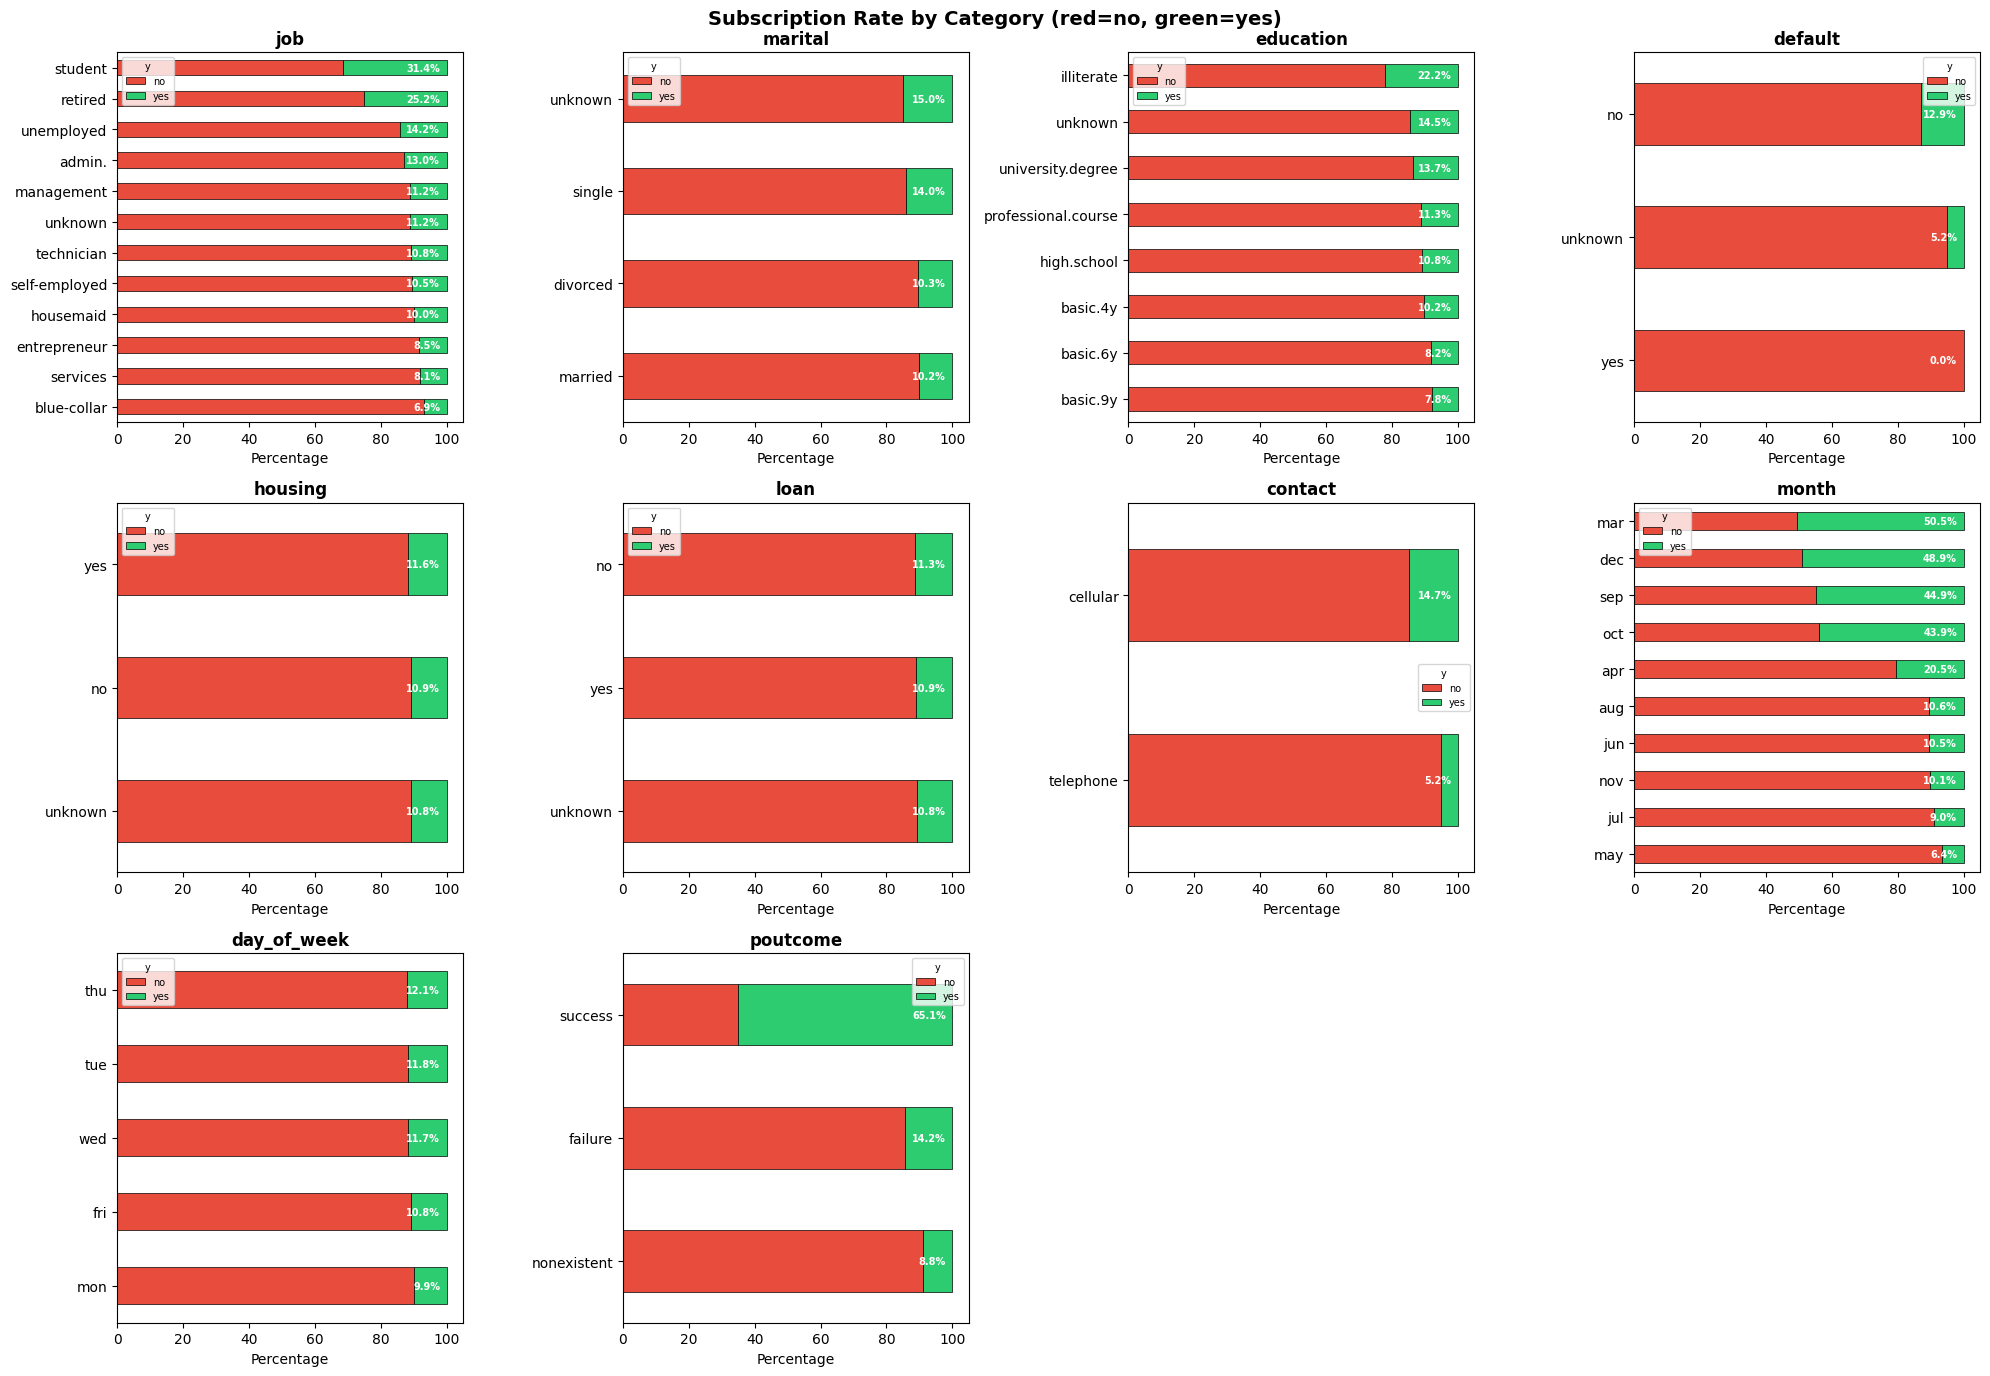


Saved: eda_categorical_vs_target.png

Subscription rates by category:
------------------------------------------------------------
  job            : highest = student              (31.4%)  |  lowest = blue-collar     (6.9%)
  marital        : highest = unknown              (15.0%)  |  lowest = married         (10.2%)
  education      : highest = illiterate           (22.2%)  |  lowest = basic.9y        (7.8%)
  default        : highest = no                   (12.9%)  |  lowest = yes             (0.0%)
  housing        : highest = yes                  (11.6%)  |  lowest = unknown         (10.8%)
  loan           : highest = no                   (11.3%)  |  lowest = unknown         (10.8%)
  contact        : highest = cellular             (14.7%)  |  lowest = telephone       (5.2%)
  month          : highest = mar                  (50.5%)  |  lowest = may             (6.4%)
  day_of_week    : highest = thu                  (12.1%)  |  lowest = mon             (9.9%)
  poutcome       : 

In [10]:
# Step 8: Feature-target relationships (categorical)
# Subscription rate per category for each categorical feature
print("=" * 60)
print("[8/12] FEATURE-TARGET RELATIONSHIPS — CATEGORICAL")
print("=" * 60)

fig, axes = plt.subplots(3, 4, figsize=(20, 14))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ax = axes[i]
    
    # Calculate subscription rate per category
    ct = pd.crosstab(df[col], df['y'], normalize='index') * 100
    ct = ct.sort_values('yes', ascending=True)
    
    # Stacked horizontal bar
    ct.plot(kind='barh', stacked=True, ax=ax, color=['#e74c3c', '#2ecc71'],
            edgecolor='black', linewidth=0.5)
    ax.set_title(col, fontweight='bold')
    ax.set_xlabel('Percentage')
    ax.set_ylabel('')
    ax.legend(title='y', fontsize=7, title_fontsize=7)
    
    # Label the "yes" percentage on each bar
    for j, (idx, row) in enumerate(ct.iterrows()):
        yes_pct = row['yes']
        ax.text(98, j, f'{yes_pct:.1f}%', va='center', ha='right',
                fontsize=7, fontweight='bold', color='white')

# Hide unused subplots
for j in range(len(cat_cols), len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Subscription Rate by Category (red=no, green=yes)', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('../data/raw/eda_categorical_vs_target.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nSaved: eda_categorical_vs_target.png")

# Print top/bottom subscription rates per feature
print("\nSubscription rates by category:")
print("-" * 60)
for col in cat_cols:
    ct = pd.crosstab(df[col], df['y'], normalize='index') * 100
    best = ct['yes'].idxmax()
    worst = ct['yes'].idxmin()
    print(f"  {col:15s}: highest = {best:20s} ({ct.loc[best, 'yes']:.1f}%)"
          f"  |  lowest = {worst:15s} ({ct.loc[worst, 'yes']:.1f}%)")

In [11]:
# Step 9: Chi-squared tests (categorical features vs target)
# Tests whether each categorical feature is statistically independent of the target
print("=" * 60)
print("[9/12] CHI-SQUARED TESTS — CATEGORICAL vs TARGET")
print("=" * 60)

print("\nNull hypothesis: feature is independent of target (y)")
print("Reject H0 if p-value < 0.05 (significant association)\n")

chi2_results = []
for col in cat_cols:
    # Contingency table: rows = categories, columns = yes/no
    contingency = pd.crosstab(df[col], df['y'])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
    
    chi2_results.append({
        'feature': col,
        'chi2': chi2,
        'p_value': p_value,
        'dof': dof,
        'significant': p_value < 0.05
    })

# Sort by chi2 statistic (strongest association first)
chi2_results.sort(key=lambda x: x['chi2'], reverse=True)

print(f"{'Feature':15s} {'Chi²':>12s} {'p-value':>14s} {'DoF':>5s}  {'Significant?'}")
print("-" * 65)
for r in chi2_results:
    sig = "YES ***" if r['p_value'] < 0.001 else "YES *" if r['significant'] else "no"
    # p-values can be extremely small — use scientific notation
    p_str = f"{r['p_value']:.2e}" if r['p_value'] < 0.001 else f"{r['p_value']:.4f}"
    print(f"{r['feature']:15s} {r['chi2']:12.1f} {p_str:>14s} {r['dof']:5d}  {sig}")

print("\nAll categorical features show significant association with the target.")
print("Ranked by chi² strength: stronger association = more useful for tree splits.")

[9/12] CHI-SQUARED TESTS — CATEGORICAL vs TARGET

Null hypothesis: feature is independent of target (y)
Reject H0 if p-value < 0.05 (significant association)

Feature                 Chi²        p-value   DoF  Significant?
-----------------------------------------------------------------
poutcome              4230.5       0.00e+00     2  YES ***
month                 3101.1       0.00e+00     9  YES ***
job                    961.2      4.19e-199    11  YES ***
contact                862.3      1.53e-189     1  YES ***
default                406.6       5.16e-89     2  YES ***
education              193.1       3.31e-38     7  YES ***
marital                122.7       2.07e-26     3  YES ***
day_of_week             26.1       2.96e-05     4  YES ***
housing                  5.7         0.0583     2  no
loan                     1.1         0.5787     2  no

All categorical features show significant association with the target.
Ranked by chi² strength: stronger association = more useful

In [ ]:
# Step 10: Normality tests (numeric features)
# D'Agostino-Pearson test — tests if data comes from a normal distribution
# Trees have NO distributional assumptions, so this is for documentation only
print("=" * 60)
print("[10/12] NORMALITY TESTS — D'AGOSTINO-PEARSON")
print("=" * 60)

print("\nNull hypothesis: data comes from a normal distribution")
print("Reject H0 if p-value < 0.05 (NOT normally distributed)")
print("Note: Trees don't assume normality — this is for comparison with")
print("models that do (Gaussian Naive Bayes, linear regression).\n")

print(f"{'Feature':20s} {'Statistic':>12s} {'p-value':>14s}  {'Normal?':>10s} {'Skewness':>10s}")
print("-" * 72)
for col in numeric_cols:
    stat, p_value = stats.normaltest(df[col])
    skew = df[col].skew()
    normal = "Yes" if p_value >= 0.05 else "No"
    p_str = f"{p_value:.2e}" if p_value < 0.001 else f"{p_value:.4f}"
    print(f"{col:20s} {stat:12.1f} {p_str:>14s}  {normal:>10s} {skew:>+10.3f}")

print("\nResult: ALL features reject normality (p ≈ 0).")
print("This confirms trees are the right choice — no distributional assumptions needed.")
print("Gaussian NB would struggle with these non-normal distributions.")

[10/12] NORMALITY TESTS — D'AGOSTINO-PEARSON

Null hypothesis: data comes from a normal distribution
Reject H0 if p-value < 0.05 (NOT normally distributed)
Note: Trees don't assume normality — this is for comparison with
models that do (e.g., Gaussian Naive Bayes, linear regression).

Feature                 Statistic        p-value     Normal?   Skewness
------------------------------------------------------------------------
age                        3904.9       0.00e+00          No     +0.785
duration                  30134.6       0.00e+00          No     +3.263
campaign                  40280.1       0.00e+00          No     +4.763
pdays                     38981.2       0.00e+00          No     -4.922
previous                  33221.5       0.00e+00          No     +3.832
emp.var.rate              16401.6       0.00e+00          No     -0.724
cons.price.idx             4390.5       0.00e+00          No     -0.231
cons.conf.idx               936.4      4.67e-204          No     

In [13]:
# Step 11: Variance Inflation Factor (VIF) — multicollinearity
# VIF > 5 = moderate, VIF > 10 = severe multicollinearity
# Trees don't suffer from this, but we document it for comparison
print("=" * 60)
print("[11/12] VIF — VARIANCE INFLATION FACTOR")
print("=" * 60)

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Use only numeric features (exclude duration — it's being dropped)
numeric_no_duration = [c for c in numeric_cols if c != 'duration']
X_vif = df[numeric_no_duration].copy()

# VIF requires adding a constant (intercept term)
X_vif['const'] = 1

print("\nComputed on numeric features (excluding duration).")
print("VIF > 5: moderate multicollinearity")
print("VIF > 10: severe — problematic for linear models, fine for trees\n")

vif_results = []
for i, col in enumerate(numeric_no_duration):
    vif = variance_inflation_factor(X_vif.values, i)
    vif_results.append({'feature': col, 'vif': vif})

vif_results.sort(key=lambda x: x['vif'], reverse=True)

print(f"{'Feature':20s} {'VIF':>10s}  {'Severity'}")
print("-" * 50)
for r in vif_results:
    if r['vif'] > 10:
        severity = "SEVERE ⚠"
    elif r['vif'] > 5:
        severity = "Moderate"
    else:
        severity = "OK"
    print(f"{r['feature']:20s} {r['vif']:10.1f}  {severity}")

print("\nFor linear/logistic regression: would need to drop or combine correlated features.")
print("For decision trees: no action needed — trees pick ONE feature per split,")
print("so correlated features just compete for the same splits harmlessly.")

[11/12] VIF — VARIANCE INFLATION FACTOR

Computed on numeric features (excluding duration).
VIF > 5: moderate multicollinearity
VIF > 10: severe — problematic for linear models, fine for trees

Feature                     VIF  Severity
--------------------------------------------------
euribor3m                  64.3  SEVERE ⚠
emp.var.rate               33.1  SEVERE ⚠
nr.employed                31.7  SEVERE ⚠
cons.price.idx              6.3  Moderate
cons.conf.idx               2.6  OK
previous                    1.8  OK
pdays                       1.6  OK
campaign                    1.0  OK
age                         1.0  OK

For linear/logistic regression: would need to drop or combine correlated features.
For decision trees: no action needed — trees pick ONE feature per split,
so correlated features just compete for the same splits harmlessly.


## EDA Summary — Preprocessing Recommendations

### Findings → Actions

| # | Finding | Evidence | Action |
|---|---------|----------|--------|
| 1 | **Class imbalance** (88.7% no / 11.3% yes) | Target distribution, 7.9:1 ratio | Stratified split + `class_weight='balanced'` |
| 2 | **`duration` is data leakage** | +150.5% mean difference, uncorrelated with other features | **Drop entirely** — not available at prediction time |
| 3 | **`pdays=999` sentinel** | 96.3% of values = 999 (never contacted) | Keep as-is — trees learn to split at threshold ~998 |
| 4 | **Outliers in campaign, previous, age** | IQR flagged 1-14% per feature | **Keep all** — trees are split-based, robust to extremes |
| 5 | **`unknown` in 6 categorical features** | `default` 20.9%, `education` 4.2%, others <2.5% | Keep as own category — trees route unknowns naturally |
| 6 | **No feature is normally distributed** | D'Agostino p ≈ 0 for all 10 numeric features | **No scaling needed** — trees are scale-invariant |
| 7 | **Severe multicollinearity** (economic indicators) | VIF: euribor3m 64.3, emp.var.rate 33.1, nr.employed 31.7 | **No action** — trees pick one feature per split |
| 8 | **10 categorical features** (2–12 categories each) | Category audit complete | **Ordinal encoding** (not one-hot) — trees split on thresholds |
| 9 | **`poutcome=success`** is strongest predictor | 65.1% subscription rate, chi² = 4230.5 | Preserve in encoding — expect high feature importance |
| 10 | **`default` nearly useless** | Only 3 "yes" values, 20.9% unknown | Keep — trees will ignore it if uninformative |

### Preprocessing Pipeline (→ `preprocess_decision_tree.py`)
1. Load raw CSV (41,188 × 21)
2. Drop `duration` (leakage)
3. Keep `unknown` as category
4. Ordinal encode all 10 categorical features
5. Encode target: yes → 1, no → 0
6. Stratified 80/20 split (`random_state=113`)
7. Save: X_train, X_test, y_train, y_test + preprocessing_info.json

**Final feature count:** 19 (9 numeric + 10 ordinally encoded categorical)